# Tensorflow COVID-19 Classification by Chest X-Ray

Import necessary module and package.

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K

from keras.models import load_model

import util

Print currently install version of Tensorflow and Keras.

In [1]:
import tensorflow as tf; print(tf.__version__)
import keras; print(keras.__version__)

2.1.0
2.3.1


Using TensorFlow backend.


Read the data.

In [4]:
train_df = pd.read_csv("data/train.csv")
valid_df = pd.read_csv("data/valid.csv")

test_df = pd.read_csv("data/test.csv")

train_df.head()

,Image,COVID19,Normal
0,COVID-19 (1).png,1,0
1,COVID-19 (10).png,1,0
2,COVID-19 (100).png,1,0
3,COVID-19 (101).png,1,0
4,COVID-19 (102).png,1,0


Define the labels.

In [5]:
labels = ['COVID19', 'Normal']

Preparing images
* Using ImageDataGenerator class from Keras to build a "generator" for images specified in a dataframe.
* Perform basic data augmentation such as random horizontal flipping of images.
* Transform the values in each batch so that their mean is 0 and their standard deviation is 1.
* Converts single channel X-ray images (gray-scale) to a three-channel format by repeating the values in the image across all channels.

In [6]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

Build a separated generator for valid and test sets.

In [7]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

Run generator for training data and one each of test and validation datasets.

In [8]:
IMAGE_DIR = "images/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train generator...
Found 353 validated image filenames.
getting train and valid generators...
Found 353 validated image filenames.
Found 133 validated image filenames.
Found 43 validated image filenames.


Picking up one of training sample to visualize.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


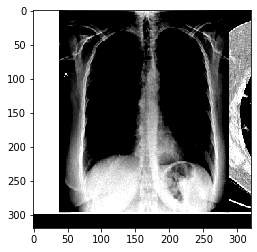

In [9]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

Checking imbalance class situation in datasets by plot the frequency of each labels in dataset.

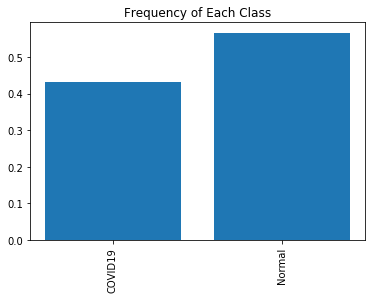

In [10]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

Function to calculate these frequences for each label in dataset.

In [11]:
def compute_class_freqs(labels):
    
    # total number of patients (rows)
    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis=0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

Loss function that calculates the weighted loss for each batch.

In [12]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class
            loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
            loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
            loss += loss_pos + loss_neg
        
        return loss

    return weighted_loss

Compute frequencies for training data.

In [13]:
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
freq_pos

array([0.43342776, 0.56657224])

Visualize these two contribution ratios of COVID19 and Normal.

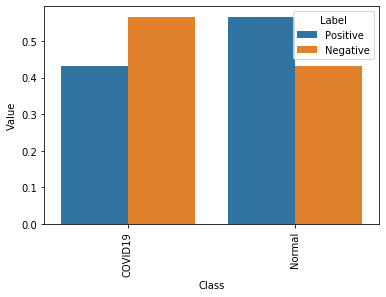

In [14]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

Re-balancing the contribution of positive and negative labels.

In [15]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Verify again by plotting the two contributions next to each other again.

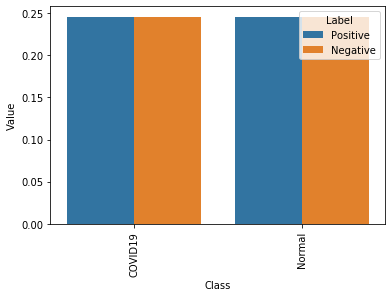

In [16]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

Load pre-trained DenseNet121 model and then add two layers on top of it.

In [17]:
# create the base pre-trained model
base_model = DenseNet121(weights='./models/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
predictions = Dense(len(labels), activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])

Start the model training.

In [18]:
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

Epoch 1/3
100/100 [==============================] - 1040s 10s/step - loss: 0.1808 - accuracy: 0.9351 - val_loss: -1.0334e-07 - val_accuracy: 0.7056
Epoch 2/3
100/100 [==============================] - 1308s 13s/step - loss: 0.0751 - accuracy: 0.9720 - val_loss: -1.0334e-07 - val_accuracy: 0.8579
Epoch 3/3
100/100 [==============================] - 1548s 15s/step - loss: 0.0961 - accuracy: 0.9756 - val_loss: -1.2318e-07 - val_accuracy: 0.8969


Plotting model training summary.

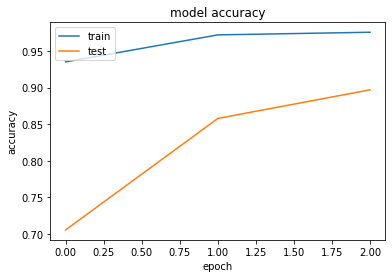

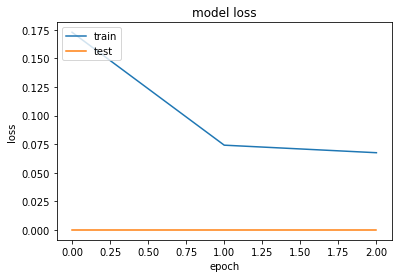

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Save the trained model in h5 format.

In [20]:
model.save('./models/my_model.h5')

Load the trained model as need.

In [21]:
#model.load_weights("./models/my_model.h5")

 Use predict_generator function to generate the prediction for the images in our test set.

In [22]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

Generate ROC curve.

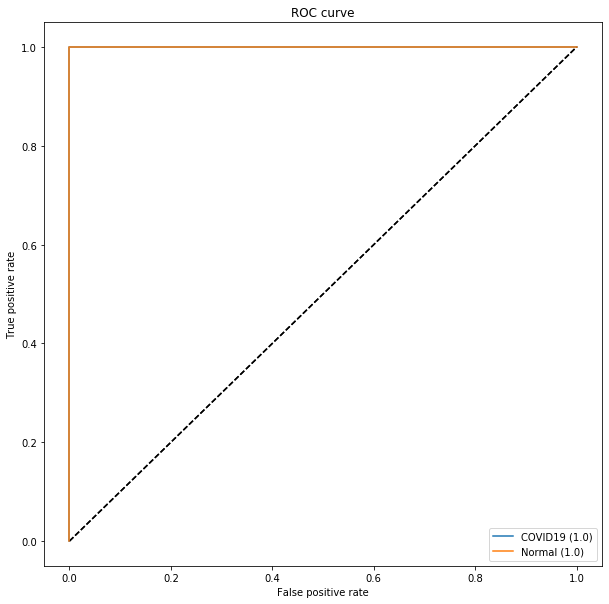

In [23]:
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

Load the data labels from data.

In [24]:
df = pd.read_csv("data/train.csv")
IMAGE_DIR = "images/"

# only show the labels with top 4 AUC
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:4]

Load test image and generate Gradcam (COVID19 Positive).

Loading original image
Generating gradcam for class COVID19
Generating gradcam for class Normal


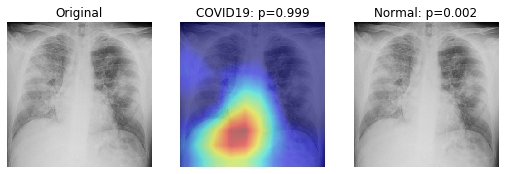

In [25]:
util.compute_gradcam(model, 'COVID-19(208).png', IMAGE_DIR, df, labels, labels_to_show)

Load test image and generate Gradcam (Normal).

Loading original image
Generating gradcam for class COVID19
Generating gradcam for class Normal


C:\Users\easlai\Documents\PyDev\Tensorflow_COVID-19_Classification_by_Chest X-Ray\util.py:57: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()
C:\Users\easlai\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\easlai\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\easlai\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\easlai\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\image.py:410: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
C:\Users\easlai\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:933: Us

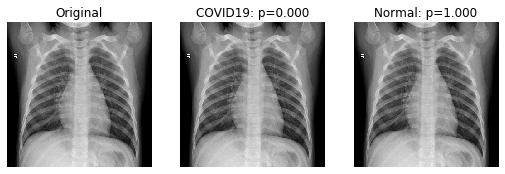

In [26]:
util.compute_gradcam(model, 'NORMAL (941).png', IMAGE_DIR, df, labels, labels_to_show)